In [197]:
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

import scipy
import pickle
import sys
# sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

In [6]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_fdata().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [5]:
meanbrain_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine_zflip_2umiso.nii"
meanbrain = np.asarray(nib.load(meanbrain_path).get_fdata().squeeze(), dtype='float32')
meanbrain = np.swapaxes(meanbrain,0,1)
meanbrain.shape

(146, 314, 91)

In [7]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
flies = ['087','089','094','097','098','099','100','101','105']

In [109]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
flies = [116,117,118,120,122,128,129,132,133,134] #failures: 115,135,138 (just need to run corr or warp or something I think)
flies = [str(i) for i in flies]

In [148]:
#gcamp8s
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
flies = [139,142,143,146,147,148,149,150,152,153]
flies = [str(i) for i in flies]

In [149]:
all_brains = {}
for behavior in ['dRotLabY', 'dRotLabZneg', 'dRotLabZpos']:
    brains = []
    for fly in flies:
        
        brainfile = os.path.join(dataset_path, 'fly_' + fly, 'warp', F'corr_{behavior}-applied-meanbrain.nii')
        try:
            brain = np.asarray(nib.load(brainfile).get_data().squeeze(), dtype='float32')
            brains.append(brain)
            print(F'{fly} success')
        except:
            print(F'{fly} failed')
    brains = np.asarray(brains)
    print(f'{behavior} done')
    all_brains[behavior] = brains

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


139 success
142 success
143 success
146 success
147 success
148 success
149 success
150 success
152 success
153 success
dRotLabY done
139 success
142 success
143 success
146 success
147 success
148 success
149 success
150 success
152 success
153 success
dRotLabZneg done
139 success
142 success
143 success
146 success
147 success
148 success
149 success
150 success
152 success
153 success
dRotLabZpos done


In [150]:
rgb_corrs = np.stack((all_brains['dRotLabZneg'], all_brains['dRotLabZpos'], all_brains['dRotLabY']))
rgb_corrs.shape

(3, 10, 314, 146, 91)

In [40]:
rgb_corrs.shape

(3, 9, 314, 146, 91)

In [10]:
analyis_path = os.path.join(dataset_path, '20220425_dataset_comparisons')
os.mkdir(analyis_path)

In [151]:
save_file = os.path.join(analyis_path, 'gcamp8s')
np.save(save_file, rgb_corrs)

In [136]:
save_file = os.path.join(analyis_path, 'gcamp6f_new.npy')
corr_map = np.load(save_file)
corr_map.shape

(3, 10, 314, 146, 91)

In [152]:
corr_map = np.mean(rgb_corrs,axis=1)
corr_map.shape

(3, 314, 146, 91)

In [105]:
corr_map_backup = corr_map.copy()

In [153]:
corr_map = np.rollaxis(corr_map,0,4)

In [154]:
corr_map = corr_map[:,:,::-1,:]

In [171]:
thresh_map = corr_map.copy()
thresh=0.02
thresh_map[np.where(corr_map<thresh)] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


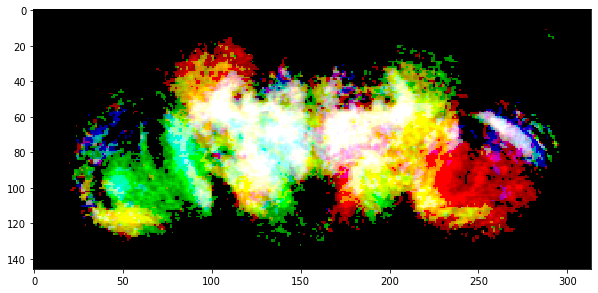

In [172]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(thresh_map[:,:,64,:]*25,0,1))

In [173]:
corr_map = thresh_map

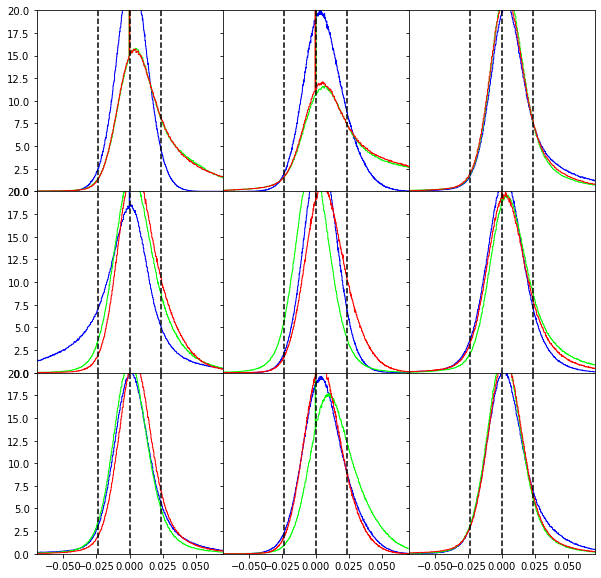

In [174]:
fig = plt.figure(figsize=(10,10))

grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0,aspect=False)

for fly_num,ax in enumerate(grid):
    ax.hist(all_brains['dRotLabY'][fly_num].flatten(),bins=1000,histtype='step',density=True,color=(0,0,1));
    ax.hist(all_brains['dRotLabZpos'][fly_num].flatten(),bins=1000,histtype='step',density=True,color=(0,1,0));
    ax.hist(all_brains['dRotLabZneg'][fly_num].flatten(),bins=1000,histtype='step',density=True,color=(1,0,0));
    ax.axvline(0,color='k',linestyle='--')
    ax.axvline(-.024,color='k',linestyle='--')
    ax.axvline(.024,color='k',linestyle='--')
    ax.set_ylim(0,20)
    ax.set_xlim(-.07,.07)


In [175]:
meanbrains = {}
for behavior in ['dRotLabY', 'dRotLabZpos', 'dRotLabZneg']:
    meanbrains[behavior] = np.mean(all_brains[behavior],axis=0)

In [15]:
out = scipy.stats.ttest_1samp(all_brains['dRotLabZpos'], axis=0, popmean=0).pvalue

/home/groups/trc/python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/groups/trc/python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/groups/trc/python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
import statsmodels

In [32]:
fdr_out = statsmodels.stats.multitest.fdrcorrection(np.nan_to_num(out.flatten()), alpha=0.05)

In [33]:
fdr_map = np.reshape(fdr_out[0], (314, 146, 91))

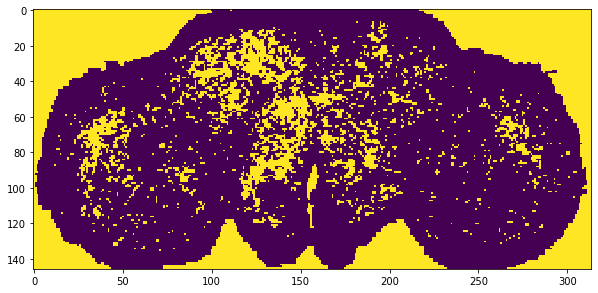

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(fdr_map[:,:,40].T)

In [35]:
fdr_masked = fdr_map*meanbrains['dRotLabZpos']

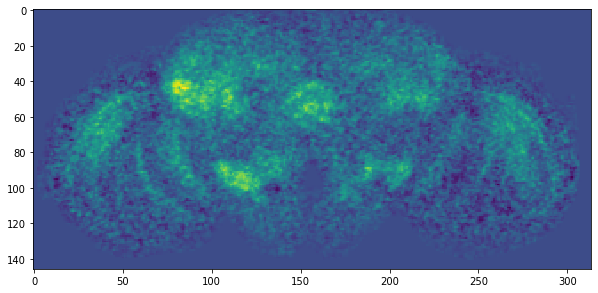

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(meanbrains['dRotLabZpos'][:,:,30].T)

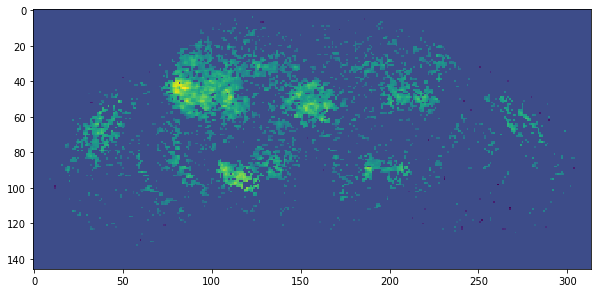

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(fdr_masked[:,:,30].T)

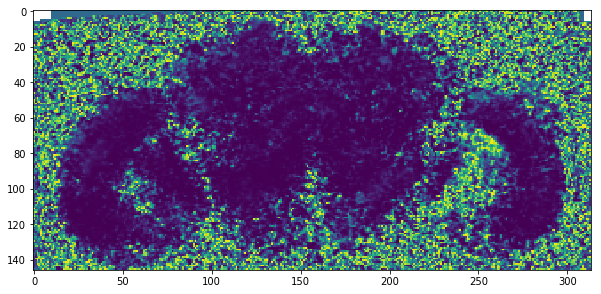

In [272]:
plt.figure(figsize=(10,10))
plt.imshow(out[:,:,40].T)

(-0.07, 0.07)

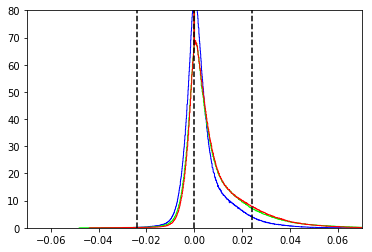

In [36]:
plt.hist(meanbrains['dRotLabY'].flatten(),bins=1000,histtype='step',density=True,color=(0,0,1));
plt.hist(meanbrains['dRotLabZpos'].flatten(),bins=1000,histtype='step',density=True,color=(0,1,0));
plt.hist(meanbrains['dRotLabZneg'].flatten(),bins=1000,histtype='step',density=True,color=(1,0,0));

plt.axvline(0,color='k',linestyle='--')
plt.axvline(-.024,color='k',linestyle='--')
plt.axvline(.024,color='k',linestyle='--')
plt.ylim(0,80)
plt.xlim(-.07,.07)

In [37]:
rgb_corrs = np.stack((meanbrains['dRotLabZneg'], meanbrains['dRotLabZpos'], meanbrains['dRotLabY']))
rgb_corrs = np.swapaxes(rgb_corrs,0,3)
rgb_corrs = np.swapaxes(rgb_corrs,0,2)
rgb_corrs.shape

(146, 314, 91, 3)

In [73]:
### MAKE ALPHA ###
alpha = np.ones(atlas.shape)
alpha[np.where(np.max(rgb_corrs,axis=-1)<0.03)]=0 # Corrs
signals_alpha = np.concatenate((rgb_corrs,alpha[..., np.newaxis]),axis=-1)
signals_alpha.shape

(146, 314, 91, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 145.5, -0.5)

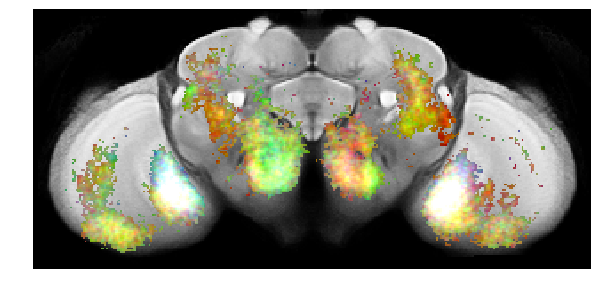

In [91]:
# # for i,z in enumerate(np.arange(91)[::-1]):
# #     print(i,z)
z=40
plt.figure(figsize=(10,10))
plt.imshow(atlas[:,:,z],cmap='gray')
plt.imshow(signals_alpha[:,:,z,:]*20)
plt.axis('off')
# # label = format(i, '03d')
# # fname = os.path.join(save_dir, f'{label}')
# # plt.savefig(fname,dpi=100,bbox_inches='tight')
# # plt.clf()



In [24]:
save_dir ='/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220421_corr_video'
os.mkdir(save_dir)

In [25]:
for i,z in enumerate(np.arange(91)[::-1]):
    print(i,z)
    plt.figure(figsize=(10,10))
    plt.imshow(atlas[:,:,z],cmap='gray')
    plt.imshow(signals_alpha[:,:,z,:]*30)
    plt.axis('off')
    label = format(i, '03d')
    fname = os.path.join(save_dir, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 84


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 83


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 82


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12 78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13 77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15 75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16 74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17 73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18 72


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19 71


/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20 70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21 69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22 68


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23 67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25 65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27 63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28 62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31 59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33 57


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34 56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35 55


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36 54


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39 51


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41 49


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42 48


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43 47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45 45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47 43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51 39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


52 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53 37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


55 35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


56 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57 33


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61 29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


63 27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


71 19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


72 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


73 17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


76 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


77 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


78 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


81 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


82 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


84 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


86 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


87 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


88 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


89 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90 0


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [296]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

NameError: name 'ants' is not defined

(-0.5, 313.5, 145.5, -0.5)

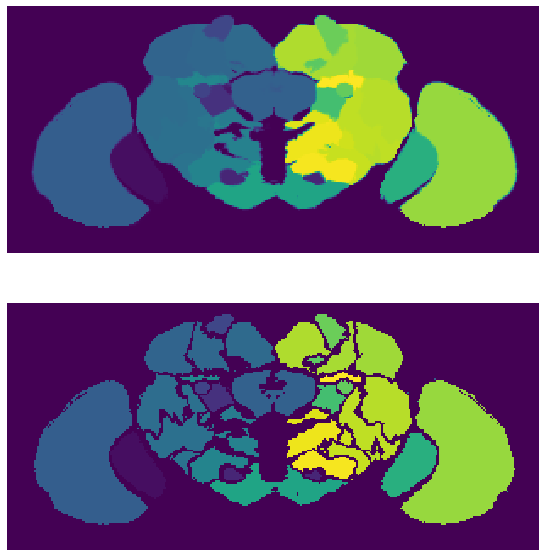

In [37]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [75]:
corr_map.shape

(314, 146, 91, 3)

In [76]:
91-27

64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


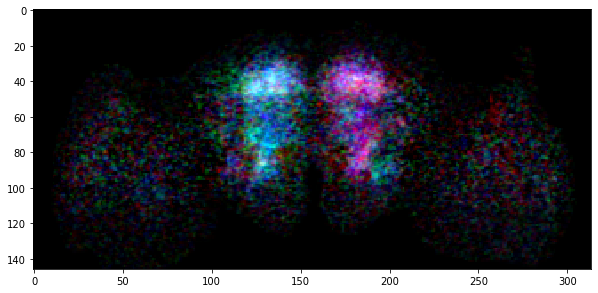

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(corr_map[:,:,64,:]*30,0,1))

In [224]:
corr_map.shape


(314, 146, 91, 3)

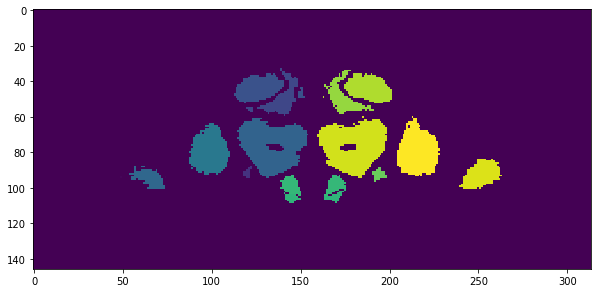

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(atlas_clean[:,:,27]*30,0,1))

In [256]:
def load_roi_atlas():
    atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
    atlas = np.asarray(nib.load(atlas_path).get_fdata().squeeze(), dtype='float32')
    atlas = ants.from_numpy(atlas)
    atlas.set_spacing((.76,.76,.76))
    atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

    atlas = atlas.numpy()
    atlas_int = np.rint(atlas)
    atlas_clean = np.copy(atlas_int)
    diff_atlas = atlas_int - atlas
    thresh = 0.001
    atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0
    return atlas_clean

def load_explosion_groups():
    explosion_rois_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220425_explosion_plot_rois.pickle'
    explosion_rois = pickle.load(open(explosion_rois_file,"rb"))
    return explosion_rois
    
def make_single_roi_masks(all_rois, atlas):
    
    masks = {}
    for roi in all_rois:
        mask = np.zeros(atlas.shape)
        mask[np.where(atlas == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)
        masks[roi] = mask_dilated

    return masks
    
def make_single_roi_contours(roi_masks, atlas):
    
    roi_contours = {}
    for roi in roi_masks:
        mask = roi_masks[roi]
        _, mask_binary = cv2.threshold(np.max(mask,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

        # get edge location
        left_edge = np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0]
        right_edge = np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1]
        top_edge = np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0]
        bottom_edge = np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1]
        
        roi_contours[roi] = {}
        roi_contours[roi]['contour'] = roi_contour
        roi_contours[roi]['left_edge'] = left_edge
        roi_contours[roi]['right_edge'] = right_edge
        roi_contours[roi]['top_edge'] = top_edge
        roi_contours[roi]['bottom_edge'] = bottom_edge
    
    return roi_contours
    
def unnest_roi_groups(explosion_rois):
    all_rois = []
    for roi_group in explosion_rois:
        all_rois.extend(explosion_rois[roi_group]['rois'].keys())
    return all_rois

def get_dim_info(item, full_x_mid, full_y_mid):
    y_mid = int(item.shape[0]/2)
    x_mid = int(item.shape[1]/2)

    height = item.shape[0]
    width = item.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height
    return {'left': left, 'right': right, 'top': top, 'bottom': bottom}

def place_roi_groups_on_canvas(explosion_rois, roi_masks, roi_contours, data_to_plot, input_canvas, gain):

    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)
    
    for roi_group in explosion_rois:
        
        x_shift = explosion_rois[roi_group]['x_shift']
        y_shift = explosion_rois[roi_group]['y_shift']
        
        roi_data = []
        left_edges = []
        right_edges = []
        bottom_edges = []
        top_edges = []
        
        for roi in explosion_rois[roi_group]['rois']:
            mask = roi_masks[roi]
            masked_roi = mask[...,np.newaxis]*data_to_plot

            ### maximum projection along z-axis
            masked_roi_flat = np.max(masked_roi,axis=2)
            roi_data.append(masked_roi_flat)
            
            left_edges.append(roi_contours[roi]['left_edge'])
            right_edges.append(roi_contours[roi]['right_edge'])
            top_edges.append(roi_contours[roi]['top_edge'])
            bottom_edges.append(roi_contours[roi]['bottom_edge'])
        
            
        # get extreme edges from all rois used
        left_edge = np.min(left_edges) - 1
        right_edge = np.max(right_edges) + 1
        top_edge = np.min(top_edges) - 1
        bottom_edge = np.max(bottom_edges) + 1
            
        ### this projects across all the roi_data from each roi 
        roi_datas = np.max(np.asarray(roi_data),axis=0)
        ### cutout this grouping
        data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)
        ### apply gain
        data_map = data_map * gain
        
        dims = get_dim_info(data_map, full_x_mid, full_y_mid)

        ### ADD TO CANVAS
        
        input_canvas[dims['top']+y_shift:dims['bottom']+y_shift,
                     dims['left']+x_shift:dims['right']+x_shift,
                     :3] = data_map
        

        ### ADD CONTOUR TO CANVAS
        
        for roi in explosion_rois[roi_group]['rois']:
            contour = roi_contours[roi]['contour']
            contour = np.swapaxes(contour[top_edge:bottom_edge,left_edge:right_edge],0,1)
            ys = np.where(contour[:,:,0]>0)[0] + dims['top'] + y_shift
            xs = np.where(contour[:,:,0]>0)[1] + dims['left'] + x_shift
            input_canvas[ys,xs]=1
        
            
    return input_canvas


In [201]:
atlas = load_roi_atlas()

In [198]:
explosion_rois = load_explosion_groups()
all_rois = unnest_roi_groups(explosion_rois)

In [208]:
roi_masks = make_single_roi_masks(all_rois, atlas)

In [215]:
roi_contours = make_single_roi_contours(roi_masks, atlas)

In [257]:
input_canvas = np.zeros((500,500,3))
data_to_plot = corr_map
gain = 20

explosion_map = place_roi_groups_on_canvas(explosion_rois, roi_masks, roi_contours, data_to_plot, input_canvas, gain)

0.002765655517578125
0.0013604164123535156
0.0013251304626464844
0.00035381317138671875
0.000347137451171875
0.010863304138183594
0.003978729248046875
0.003944873809814453
0.00037550926208496094
0.0003800392150878906
0.0003685951232910156
0.00036978721618652344
0.0003514289855957031
0.00036597251892089844
0.0003542900085449219
0.0003821849822998047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


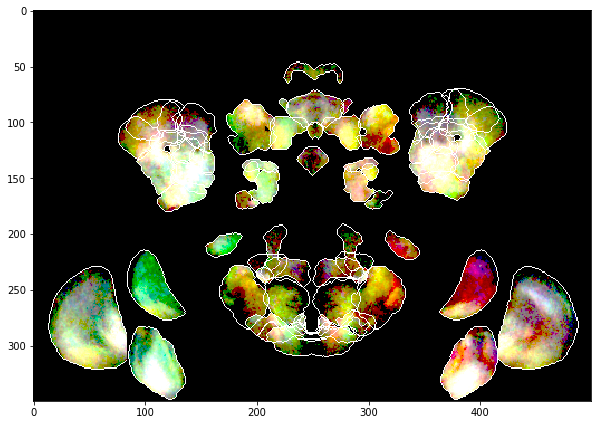

In [247]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

In [181]:
###############
### For RGB ###
###############

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        # do i need this?
        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        masked_roi = mask_dilated[...,np.newaxis]*corr_map

        ### maximum projection along z-axis
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)

        #######################
        ### Get roi contour ###
        #######################
        ### this just takes the roi mask and extracts the edge (contour)
        ### 
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    # 
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    ### this projects across all the roi_data from each roi 
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*15#*10000#*20 #here

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [190]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

roi_groups = {'FB_group': {'rois': FB_group, 'x_shift': 0, 'y_shift': 0},
              'ventromedial_r_group': {'rois': ventromedial_r_group, 'x_shift': -50, 'y_shift': 55},
              'ventromedial_l_group': {'rois': ventromedial_l_group, 'x_shift': 50, 'y_shift': 55},
              'PB': {'rois': PB, 'x_shift': 0, 'y_shift': -45},
              'EB': {'rois': EB, 'x_shift': 0, 'y_shift': 35},
              'anterior_group': {'rois': anterior_group, 'x_shift': 0, 'y_shift': 150},
              'dorsal_posterior_r_group': {'rois': big_r_group, 'x_shift': -130, 'y_shift': 30},
              'dorsal_posterior_l_group': {'rois': big_l_group, 'x_shift': 130, 'y_shift': 20},
              'MED_R': {'rois': {25: 'MED_R'}, 'x_shift': -200, 'y_shift': 175},
              'MED_L': {'rois': {71: 'MED_L'}, 'x_shift': 200, 'y_shift': 175},
              'LO_R': {'rois': {3: 'LO_R'}, 'x_shift': -140, 'y_shift': 215},
              'LO_L': {'rois': {53: 'LO_L'}, 'x_shift': 140, 'y_shift': 215},
              'LP_R': {'rois': {22: 'LP_R'}, 'x_shift': -140, 'y_shift': 145},
              'LP_L': {'rois': {69: 'LP_L'}, 'x_shift': 140, 'y_shift': 145},
              'AOTU_R': {'rois': {34: 'AOTU_R'}, 'x_shift': -80, 'y_shift': 110},
              'AOTU_L': {'rois': {79: 'AOTU_L'}, 'x_shift': 80, 'y_shift': 110},
             }


110

In [183]:
# mostly i call plot_grouped_roi_image to get
# data_map, contours
# which I then pass to place_on_canvas_wrapper, which returns
# canvas

# later i switch to wraper_wraper which takes and returns
# canvas

# it is not necessary to make the different grouped rois separately - this is very confusing
# 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


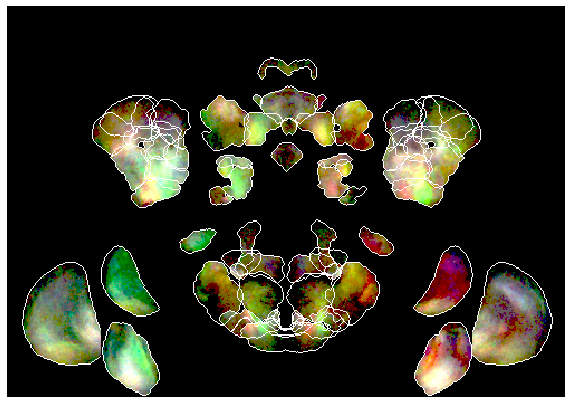

In [184]:
input_canvas = np.zeros((500,500,3))
#input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],vmax=0.07)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [80]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import time